In [119]:
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import *
from PIL import Image
import os


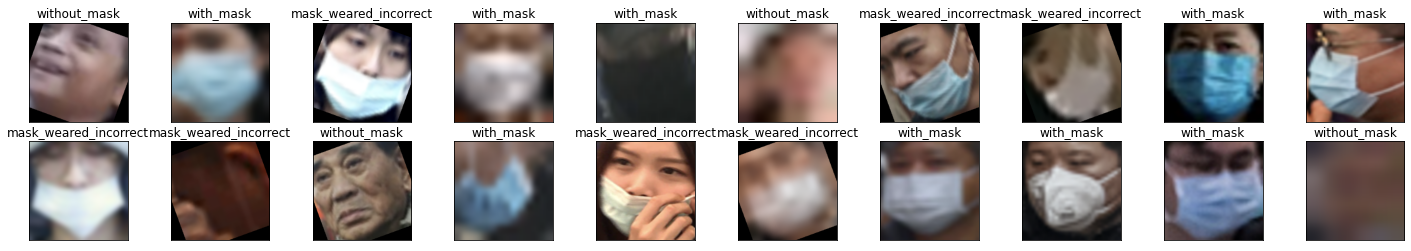

In [45]:
# file path of training, validating and testing data in Google drive
train_path = 'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\training'
val_path = 'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\validation'
test_path = 'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\testing'

# transform setting
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor()])

# Load data from Google Drive
train_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
val_set = torchvision.datasets.ImageFolder(val_path, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_path, transform=transform)
# overfit_set = torchvision.datasets.ImageFolder(overfit_path, transform=transform)

# Verification Step - obtain one batch of images
dataiter = iter(torch.utils.data.DataLoader(train_set, batch_size=27, num_workers=1, shuffle=True))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [220]:
resnet18 = models.resnet18(pretrained=True)
layer = resnet18._modules.get('avgpool')
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [221]:
preprocess = transforms.Compose([
    transforms.Scale(224, 224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def extract_feature(img_path):
    img = Image.open(img_path).convert('RGB')

    input_tensor = preprocess(img)
    input_batch = Variable(input_tensor.unsqueeze(0))

    feature = torch.zeros(512)
    def copy_data(m, i, o):
        feature.copy_(o.data.reshape(o.data.size(1)))

    h = layer.register_forward_hook(copy_data)

    resnet18(input_batch)

    h.remove()
    return feature

In [224]:
ex = train_path + "\\with_mask\\970.png"
vec = extract_feature(ex)
print(vec)

tensor([1.6547e-02, 5.0859e-01, 1.0437e+00, 3.5477e-01, 3.6290e-02, 6.4977e-01,
        1.3599e+00, 1.9671e-01, 4.0484e-03, 3.3061e-01, 4.8678e-01, 4.4996e-01,
        4.1758e-01, 8.1603e-03, 1.5406e+00, 8.2148e-01, 8.4226e-01, 6.9718e-01,
        6.7142e-01, 1.4186e+00, 2.1097e-01, 2.7491e-01, 7.2017e-01, 1.5532e-01,
        8.8872e-01, 1.4554e-02, 4.2177e-01, 7.9566e-01, 3.5310e-02, 5.0411e-01,
        9.1911e-01, 9.5856e-01, 3.7283e-02, 8.1924e-01, 6.7682e-01, 2.8342e-01,
        7.2492e-01, 7.0084e-01, 7.6869e-01, 1.8467e-01, 3.7651e-01, 3.2472e-01,
        2.6916e+00, 1.1735e+00, 1.1088e+00, 7.3218e-01, 4.5171e-01, 4.3237e-01,
        1.7667e-01, 1.3514e-01, 1.2657e+00, 4.4955e-01, 8.5864e-02, 1.3816e+00,
        6.4769e-03, 2.9040e-01, 4.8892e-01, 9.1879e-01, 1.6984e+00, 1.6706e-01,
        6.3319e-01, 2.6369e-01, 2.0091e+00, 7.5435e-01, 6.8607e-02, 2.3881e-01,
        1.5574e+00, 2.2583e-01, 0.0000e+00, 7.0982e-01, 1.9475e-02, 2.9105e-01,
        4.2545e-01, 1.0479e+00, 6.3815e-

In [141]:
# =============================
#  resnet18
#  run only once
# =============================

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, 
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, 
                                            num_workers=1, shuffle=True)

loaders = [train_loader, val_loader, test_loader]
feature_paths = ['C:\\Users\\jerry\\Downloads\\aps360\\feature\\resnet\\training\\', 
         'C:\\Users\\jerry\\Downloads\\aps360\\feature\\resnet\\validation\\', 
         'C:\\Users\\jerry\\Downloads\\aps360\\feature\\resnet\\testing\\']

data_paths = ['C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\training',
        'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\validation',
        'C:\\Users\\jerry\\Downloads\\aps360\\better_augmented\\testing']

labels = ['with_mask', 'without_mask', 'mask_weared_incorrect']

for step in range(3):
    n = 0
    for label in labels:
        for filename in os.listdir(data_paths[step] + "\\" + label):
            if filename.endswith('.png'):
                image_path = data_paths[step] + "\\" + label + "\\" + filename
                feature_tensor = extract_feature(image_path)
                feature_path = feature_paths[step] + label + "\\"
                torch.save(feature_tensor, feature_path + str(n) + ".tensor")
                if step == 0 and label == "with_mask" and filename == "970.png":
                    print("image_path: ", image_path)
                    print("feature_tensor: ", feature_tensor)
                    print("save_path: ", feature_path + str(n) + ".tensor")
                n += 1
print("done")

image_path:  C:\Users\jerry\Downloads\aps360\better_augmented\training\with_mask\970.png
feature_tensor:  tensor([1.6547e-02, 5.0859e-01, 1.0437e+00, 3.5477e-01, 3.6290e-02, 6.4977e-01,
        1.3599e+00, 1.9671e-01, 4.0484e-03, 3.3061e-01, 4.8678e-01, 4.4996e-01,
        4.1758e-01, 8.1603e-03, 1.5406e+00, 8.2148e-01, 8.4226e-01, 6.9718e-01,
        6.7142e-01, 1.4186e+00, 2.1097e-01, 2.7491e-01, 7.2017e-01, 1.5532e-01,
        8.8872e-01, 1.4554e-02, 4.2177e-01, 7.9566e-01, 3.5310e-02, 5.0411e-01,
        9.1911e-01, 9.5856e-01, 3.7283e-02, 8.1924e-01, 6.7682e-01, 2.8342e-01,
        7.2492e-01, 7.0084e-01, 7.6869e-01, 1.8467e-01, 3.7651e-01, 3.2472e-01,
        2.6916e+00, 1.1735e+00, 1.1088e+00, 7.3218e-01, 4.5171e-01, 4.3237e-01,
        1.7667e-01, 1.3514e-01, 1.2657e+00, 4.4955e-01, 8.5864e-02, 1.3816e+00,
        6.4769e-03, 2.9040e-01, 4.8892e-01, 9.1879e-01, 1.6984e+00, 1.6706e-01,
        6.3319e-01, 2.6369e-01, 2.0091e+00, 7.5435e-01, 6.8607e-02, 2.3881e-01,
        1.5574

In [145]:
tensor = torch.load('C:\\Users\\jerry\\Downloads\\aps360\\feature\\resnet\\training\\with_mask\\2232.tensor')
print(tensor)
tensor.size()

tensor([1.6547e-02, 5.0859e-01, 1.0437e+00, 3.5477e-01, 3.6290e-02, 6.4977e-01,
        1.3599e+00, 1.9671e-01, 4.0484e-03, 3.3061e-01, 4.8678e-01, 4.4996e-01,
        4.1758e-01, 8.1603e-03, 1.5406e+00, 8.2148e-01, 8.4226e-01, 6.9718e-01,
        6.7142e-01, 1.4186e+00, 2.1097e-01, 2.7491e-01, 7.2017e-01, 1.5532e-01,
        8.8872e-01, 1.4554e-02, 4.2177e-01, 7.9566e-01, 3.5310e-02, 5.0411e-01,
        9.1911e-01, 9.5856e-01, 3.7283e-02, 8.1924e-01, 6.7682e-01, 2.8342e-01,
        7.2492e-01, 7.0084e-01, 7.6869e-01, 1.8467e-01, 3.7651e-01, 3.2472e-01,
        2.6916e+00, 1.1735e+00, 1.1088e+00, 7.3218e-01, 4.5171e-01, 4.3237e-01,
        1.7667e-01, 1.3514e-01, 1.2657e+00, 4.4955e-01, 8.5864e-02, 1.3816e+00,
        6.4769e-03, 2.9040e-01, 4.8892e-01, 9.1879e-01, 1.6984e+00, 1.6706e-01,
        6.3319e-01, 2.6369e-01, 2.0091e+00, 7.5435e-01, 6.8607e-02, 2.3881e-01,
        1.5574e+00, 2.2583e-01, 0.0000e+00, 7.0982e-01, 1.9475e-02, 2.9105e-01,
        4.2545e-01, 1.0479e+00, 6.3815e-

torch.Size([512])

In [130]:
for step in range(3):
    n = 0
    for label in labels:
        for filename in os.listdir(data_paths[step] + "\\" + label):
            if step == 0 and label == "with_mask" and filename == "970.png":
                image_path = data_paths[step] + "\\" + label + "\\" + filename
                print("image_path: ", image_path)
                feature_tensor = extract_feature(image_path)
                print("tensor: ", feature_tensor)
                feature_path = feature_paths[step] + label + "\\"
                print("save_path: ",feature_path + str(n) + ".tensor")
                break

image_path:  C:\Users\jerry\Downloads\aps360\better_augmented\training\with_mask\970.png
tensor:  tensor([1.6547e-02, 5.0859e-01, 1.0437e+00, 3.5477e-01, 3.6290e-02, 6.4977e-01,
        1.3599e+00, 1.9671e-01, 4.0484e-03, 3.3061e-01, 4.8678e-01, 4.4996e-01,
        4.1758e-01, 8.1603e-03, 1.5406e+00, 8.2148e-01, 8.4226e-01, 6.9718e-01,
        6.7142e-01, 1.4186e+00, 2.1097e-01, 2.7491e-01, 7.2017e-01, 1.5532e-01,
        8.8872e-01, 1.4554e-02, 4.2177e-01, 7.9566e-01, 3.5310e-02, 5.0411e-01,
        9.1911e-01, 9.5856e-01, 3.7283e-02, 8.1924e-01, 6.7682e-01, 2.8342e-01,
        7.2492e-01, 7.0084e-01, 7.6869e-01, 1.8467e-01, 3.7651e-01, 3.2472e-01,
        2.6916e+00, 1.1735e+00, 1.1088e+00, 7.3218e-01, 4.5171e-01, 4.3237e-01,
        1.7667e-01, 1.3514e-01, 1.2657e+00, 4.4955e-01, 8.5864e-02, 1.3816e+00,
        6.4769e-03, 2.9040e-01, 4.8892e-01, 9.1879e-01, 1.6984e+00, 1.6706e-01,
        6.3319e-01, 2.6369e-01, 2.0091e+00, 7.5435e-01, 6.8607e-02, 2.3881e-01,
        1.5574e+00, 2.

In [144]:
feature_train_set = torchvision.datasets.DatasetFolder(feature_paths[0], loader=torch.load, extensions=('.tensor'))
feature_val_set = torchvision.datasets.DatasetFolder(feature_paths[1], loader=torch.load, extensions=('.tensor'))
feature_test_set = torchvision.datasets.DatasetFolder(feature_paths[2], loader=torch.load, extensions=('.tensor'))
# feature_overfit_train_set = torchvision.datasets.DatasetFolder('C:\\Users\\jerry\\Downloads\\aps360\\feature\\overfit\\training\\', loader=torch.load, extensions=('.tensor'))
# feature_overfit_val_set = torchvision.datasets.DatasetFolder('C:\\Users\\jerry\\Downloads\\aps360\\feature\\overfit\\validation\\', loader=torch.load, extensions=('.tensor'))

feature_alexnet_train_set = torchvision.datasets.DatasetFolder('C:\\Users\\jerry\\Downloads\\aps360\\feature\\alexnet\\training\\', loader=torch.load, extensions=('.tensor'))
feature_alexnet_validation_set = torchvision.datasets.DatasetFolder('C:\\Users\\jerry\\Downloads\\aps360\\feature\\alexnet\\validation\\', loader=torch.load, extensions=('.tensor'))

In [194]:
feature_train_loader = torch.utils.data.DataLoader(feature_train_set, batch_size=1, num_workers=1, shuffle=True)
feature_val_loader = torch.utils.data.DataLoader(feature_val_set, batch_size=1, num_workers=1, shuffle=True)
feature_test_loader = torch.utils.data.DataLoader(feature_test_set, batch_size=1, num_workers=1, shuffle=True)
feature_overfit_train_loader = torch.utils.data.DataLoader(feature_overfit_train_set, batch_size=1, num_workers=1, shuffle=True)
feature_overfit_val_loader = torch.utils.data.DataLoader(feature_overfit_val_set, batch_size=1, num_workers=1, shuffle=True)

In [147]:
def get_accuracy(model, train_set, val_set, train=False):
    if train:
        data = train_set
    else:
        data = val_set
   
    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total


In [148]:
def train (model, train_set, val_set, batch_size=32, learning_rate=0.0001, num_epoch=1):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epoch):
        print("epoch: ", epoch)
        for imgs, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        iters.append(epoch)
        losses.append(float(loss) / batch_size)
        train_acc.append(get_accuracy(model, train_set, val_set, train=True))
        val_acc.append(get_accuracy(model, train_set, val_set, train=False))

        print("epoch: {}, training_accuracy:{}, validation_accuracy:{}".format(epoch, train_acc[-1], val_acc[-1]))
    plt.title("training_loss")
    plt.plot(iters, losses, label="loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

    plt.title("accuracy")
    plt.plot(iters, train_acc, label="train")
    plt.plot(iters, val_acc, label="validation")
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.legend(loc='best')
    plt.show

    print ("Final training accuracy:{}".format(train_acc[-1]))
    print ("Final validation accuracy:{}".format(val_acc[-1]))


In [190]:
def evaluate(model, test_set):
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(test_set):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [177]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(512, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        x = x.view(-1, 512) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [239]:
def get_accuracy_each_class(model, data_loader, v_class):
  
  # for the later dropout model, use this to flag testing mode
  #model.eval()
  
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    if labels == v_class: 
      # print(labels)

      # enable GPU
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)

      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

epoch:  0
epoch: 0, training_accuracy:0.5740987983978638, validation_accuracy:0.5864485981308412
epoch:  1
epoch: 1, training_accuracy:0.6144859813084113, validation_accuracy:0.618380062305296
epoch:  2
epoch: 2, training_accuracy:0.6346795727636849, validation_accuracy:0.631619937694704
epoch:  3
epoch: 3, training_accuracy:0.6613818424566088, validation_accuracy:0.6495327102803738
epoch:  4
epoch: 4, training_accuracy:0.6757343124165555, validation_accuracy:0.6503115264797508
epoch:  5
epoch: 5, training_accuracy:0.6947596795727636, validation_accuracy:0.6876947040498442
epoch:  6
epoch: 6, training_accuracy:0.7039385847797063, validation_accuracy:0.6736760124610592
epoch:  7
epoch: 7, training_accuracy:0.7236315086782377, validation_accuracy:0.7071651090342679
epoch:  8
epoch: 8, training_accuracy:0.7273030707610146, validation_accuracy:0.7009345794392523
epoch:  9
epoch: 9, training_accuracy:0.7371495327102804, validation_accuracy:0.7165109034267912
epoch:  10
epoch: 10, training_a

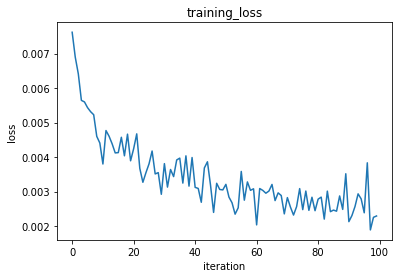

Final training accuracy:0.8681575433911882
Final validation accuracy:0.8060747663551402


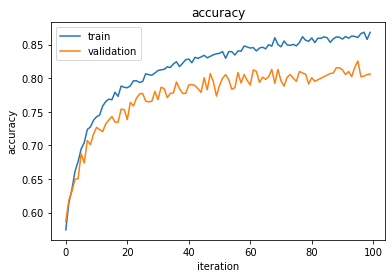

In [183]:
use_cuda = True
torch.manual_seed(1)
model_ANN_with_dropout_100 = ANNClassifier_dropout_100()
if use_cuda and torch.cuda.is_available():
    model_ANN_with_dropout_100.cuda()
train(model_ANN_with_dropout_100, feature_train_set, feature_val_set, batch_size=128, learning_rate=0.0005, num_epoch=100)

In [186]:
#Artifical Neural Network Architecture
class ANNClassifier_dropout_100(nn.Module):
    def __init__(self):
        super(ANNClassifier_dropout_100, self).__init__()
        self.fc1 = nn.Linear(512, 100)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 3)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 512) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = self.fc2(self.dropout2(x))
        return x

epoch:  0
epoch: 0, training_accuracy:0.6438584779706275, validation_accuracy:0.6503115264797508
epoch:  1
epoch: 1, training_accuracy:0.704105473965287, validation_accuracy:0.677570093457944
epoch:  2
epoch: 2, training_accuracy:0.742656875834446, validation_accuracy:0.7383177570093458
epoch:  3
epoch: 3, training_accuracy:0.7601802403204272, validation_accuracy:0.7445482866043613
epoch:  4
epoch: 4, training_accuracy:0.7658544726301736, validation_accuracy:0.7328660436137072
epoch:  5
epoch: 5, training_accuracy:0.7828771695594126, validation_accuracy:0.7461059190031153
epoch:  6
epoch: 6, training_accuracy:0.7815420560747663, validation_accuracy:0.7733644859813084
epoch:  7
epoch: 7, training_accuracy:0.8004005340453939, validation_accuracy:0.780373831775701
epoch:  8
epoch: 8, training_accuracy:0.8009012016021362, validation_accuracy:0.7531152647975078
epoch:  9
epoch: 9, training_accuracy:0.8149198931909212, validation_accuracy:0.7780373831775701
epoch:  10
epoch: 10, training_acc

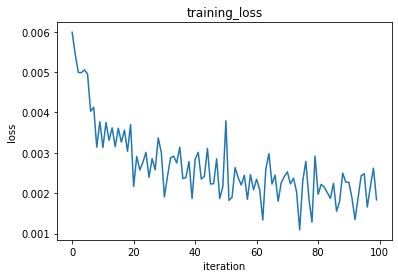

Final training accuracy:0.9060413885180241
Final validation accuracy:0.8348909657320872


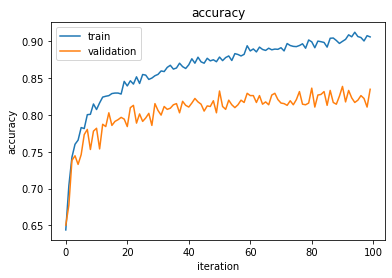

In [188]:
use_cuda = True
torch.manual_seed(1)
model_ANN_with_dropout_1000 = ANNClassifier_dropout_1000()
if use_cuda and torch.cuda.is_available():
    model_ANN_with_dropout_1000.cuda()
train(model_ANN_with_dropout_1000, feature_train_set, feature_val_set, batch_size=128, learning_rate=0.001, num_epoch=100)

In [193]:
test_accuracy = evaluate(model_ANN_with_dropout_1000, feature_test_set)
print("test_accuracy: ", test_accuracy)

test_accuracy:  0.8730529595015576


In [197]:
tensor = torch.load('C:\\Users\\jerry\\Downloads\\aps360\\feature\\alexnet\\training\\with_mask\\1.tensor')
print(tensor.size())

torch.Size([256, 6, 6])


In [196]:

mask_weared_incorrect_accuracy = get_accuracy_each_class(model_ANN_with_dropout_1000, feature_test_loader, 0)
with_mask_accuracy = get_accuracy_each_class(model_ANN_with_dropout_1000, feature_test_loader, 1)
without_mask_accuracy = get_accuracy_each_class(model_ANN_with_dropout_1000, feature_test_loader, 2)

print("class=mask_worn_incorrectly, accuracy={}\nclass=with_mask, accuracy={}\nclass=without_mask, accuracy={}".format(mask_weared_incorrect_accuracy, with_mask_accuracy, without_mask_accuracy))

class=mask_worn_incorrectly, accuracy=0.7208672086720868
class=with_mask, accuracy=0.9463917525773196
class=without_mask, accuracy=0.9209302325581395


In [187]:
#Artifical Neural Network Architecture
class ANNClassifier_dropout_1000(nn.Module):
    def __init__(self):
        super(ANNClassifier_dropout_1000, self).__init__()
        self.fc1 = nn.Linear(512, 1000)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1000, 3)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 512) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = self.fc2(self.dropout2(x))
        return x

In [226]:
# =============================
#  resnet18
#  run only once
# =============================

our_data_loader = torch.utils.data.DataLoader(our_data_set, batch_size=1, 
                                           num_workers=1, shuffle=True)

save_paths = 'C:\\Users\\jerry\\Downloads\\aps360\\our_feature\\'

labels = ['with_mask', 'without_mask', 'mask_weared_incorrect']

n = 0
for label in labels:
    for filename in os.listdir(our_data_path + "\\" + label):
        if filename.endswith('.png'):
            image_path = our_data_path + "\\" + label + "\\" + filename
            feature_tensor = extract_feature(image_path)
            feature_path = save_paths + label + "\\"
            torch.save(feature_tensor, feature_path + str(n) + ".tensor")
            n += 1
            
print("done")

done


In [249]:
our_feature_set = torchvision.datasets.DatasetFolder('C:\\Users\\jerry\\Downloads\\aps360\\our_feature\\', loader=torch.load, extensions=('.tensor'))
our_feature_loader = torch.utils.data.DataLoader(our_feature_set, batch_size=1, num_workers=1, shuffle=True)

In [250]:
tensor = torch.load('C:\\Users\\jerry\\Downloads\\aps360\\our_feature\\with_mask\\0.tensor')
print(tensor)

tensor([3.5192e-01, 2.5192e+00, 1.3352e+00, 1.7686e+00, 1.4839e+00, 7.9489e-01,
        1.5912e-01, 2.8418e+00, 8.6507e-01, 1.1232e+00, 2.5437e+00, 4.8343e-01,
        2.9730e-01, 7.4165e-01, 2.0059e+00, 7.9465e-01, 6.4692e-01, 1.1814e+00,
        0.0000e+00, 0.0000e+00, 2.3374e-03, 1.3812e+00, 3.2995e+00, 8.5066e-02,
        7.1988e-02, 6.8962e-01, 3.5052e-02, 1.0346e+00, 1.5136e-01, 1.6409e-01,
        1.3644e+00, 2.0060e-01, 9.3746e-01, 6.9304e-02, 1.1153e+00, 5.9377e-02,
        6.6828e-01, 2.1122e-01, 2.7769e-01, 7.8418e-02, 3.8498e+00, 2.2995e+00,
        7.2587e-01, 1.3927e+00, 4.9407e+00, 7.5226e+00, 0.0000e+00, 3.0551e-01,
        3.6798e+00, 1.7260e+00, 1.1283e+00, 7.5120e-01, 1.7085e-01, 1.2296e-01,
        1.8008e+00, 8.7161e-01, 6.9025e-01, 1.1562e+00, 5.5414e-01, 3.3683e-01,
        1.3795e-01, 4.7803e-02, 1.5453e-01, 4.4581e-01, 6.1225e-01, 5.4677e-01,
        2.2403e+00, 7.4346e-02, 4.0028e-01, 9.1647e-01, 3.0074e+00, 1.9156e+00,
        3.0674e-01, 7.6389e-02, 6.6021e-

In [297]:
def evaluate_our_data(model, data_loader, v_class):
  
  # for the later dropout model, use this to flag testing mode
  #model.eval()
  
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    if labels == v_class: 
      # print(labels)

      # enable GPU
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)

      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      if not pred.eq(labels.view_as(pred)):
          print("prediction={}, true_label={}".format(pred, labels))
          plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
      total += imgs.shape[0]
  return correct / total


In [298]:
mask_weared_incorrect_accuracy = evaluate_our_data(model_ANN_with_dropout_1000, our_feature_loader, 0)
with_mask_accuracy = evaluate_our_data(model_ANN_with_dropout_1000, our_feature_loader, 1)
without_mask_accuracy = evaluate_our_data(model_ANN_with_dropout_1000, our_feature_loader, 2)

print("class=mask_worn_incorrectly, accuracy={}\nclass=with_mask, accuracy={}\nclass=without_mask, accuracy={}".format(mask_weared_incorrect_accuracy, with_mask_accuracy, without_mask_accuracy))

RuntimeError: CUDA error: an illegal memory access was encountered

In [214]:
our_data_path = 'C:\\Users\\jerry\\Downloads\\aps360\\our_data'
# transform setting
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor()])

# Load data from Google Drive
our_data_set = torchvision.datasets.ImageFolder(our_data_path, transform=transform)
